# Can only be run on your desktop!!!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
import numpy as np
from utils import *
import os
from keras_self_attention import *
import matplotlib.pyplot as plt
import pypianoroll
from utils import *
from glob import glob
from generator import *
from tqdm import tqdm
import subprocess
import sys

Using TensorFlow backend.


# Load dataset

In [3]:
import shutil

from config import datasets

sys.path.append("d:/data/magenta-1.0.2/magenta/models/score2perf/")
sys.path.append("preprocessing/")
sys.path.append("D:\\data\\magenta-1.0.2\\magenta\\music")

import encoders
import my_encoder

import transpose

import melodies_lib

import midi_io

from melody_encoder_decoder import MelodyOneHotEncoding

C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or 

C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or 

In [4]:
print(datasets)

{'HOOK_100k_melody': {'path': 'D:/data/hooktheory_dataset/00melody/HOOK_100k_melody.dat', 'shape': (93667, 64, 90)}, 'FOLK_100k_melody': {'path': 'D:/data/folkdataset/00melody/FOLK_100k_melody.dat', 'shape': (100000, 64, 58)}, 'HOOK_100k_pianoroll': {'path': 'D:/data/hooktheory_dataset/00pianoroll/HOOK_100k_pianoroll.dat', 'shape': (95661, 64, 88)}, 'FOLK_100k_pianoroll': {'path': 'D:/data/folkdataset/00pianoroll/FOLK_100k_pianoroll.dat', 'shape': (100000, 64, 56)}}


In [42]:
dataset = datasets['FOLK_100k_melody']
dshape = dataset['shape']
print(dshape)
INPUT_SEQ_LEN = dshape[1]-1
print(INPUT_SEQ_LEN)

(100000, 64, 58)
63


# Load model

In [39]:
MODEL_ID = 'model_folk100k_melody_bi2lstm32_attention'
json_model = open(os.path.join(MODEL_ID,"model.json"),"r").read()
model = keras.models.model_from_json(json_model, custom_objects=SeqWeightedAttention.get_custom_objects())
model.load_weights(os.path.join(MODEL_ID, "model.h5"))
model.summary(line_length=100)

C:\Anaconda3\envs\magenta36_1\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='model_folk100k_melody_bi2lstm32_attention\\model.json' mode='r' encoding='cp1252'>
  


____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
Input (InputLayer)                           (None, 63, 58)                          0              
____________________________________________________________________________________________________
bi1 (Bidirectional)                          (None, 63, 64)                          23296          
____________________________________________________________________________________________________
bi2 (Bidirectional)                          (None, 63, 64)                          24832          
____________________________________________________________________________________________________
Attention (SeqWeightedAttention)             (None, 64)                              65             
___________________________________________________________________________________________

## Change architecture to extract attention weights

In [29]:
inputs = keras.layers.Input(
    shape=(dshape[1]-1, dshape[2],), name='Input')

lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(
            32,
            dropout=0.4,
            name="LSTM",
            return_sequences=True),
        name="bi1"
    )(inputs)

lstm2 = keras.layers.Bidirectional(
    keras.layers.LSTM(
        32,
        dropout=0.4,
        name="LSTM2",
        return_sequences=True),
    name="bi2"
)(lstm)

attention = SeqWeightedAttention(
    return_attention=True, 
    name='Attention'
)
# TODO weights
attention, weights = attention(lstm2)

dense = keras.layers.Dense(
    dshape[2], activation='softmax', name="dense_outputs")(attention)

model = keras.Model(inputs=inputs, outputs=[dense, weights])

In [30]:
model.load_weights(os.path.join(MODEL_ID, "model.h5"))
model.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
Input (InputLayer)                           (None, 63, 90)                          0              
____________________________________________________________________________________________________
bi1 (Bidirectional)                          (None, 63, 64)                          31488          
____________________________________________________________________________________________________
bi2 (Bidirectional)                          (None, 63, 64)                          24832          
____________________________________________________________________________________________________
Attention (SeqWeightedAttention)             [(None, 64), (None, 63)]                65             
___________________________________________________________________________________________

# Sampling

In [43]:
file = "d://data/folkdataset/seeds/sessiontune83.mid"
unique_name = ''.join(file.split(os.path.sep)[-1].split(".mid")[:-1])

if not os.path.exists('midi_seeds_transposed'):
    os.mkdir('midi_seeds_transposed')

transpose.main([file], os.path.abspath("midi_seeds_transposed/"))

transposed_seed = os.path.abspath(glob(os.path.join("midi_seeds_transposed",unique_name)+"*")[0])
print(transposed_seed)

transposing...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


d:\data\folkdataset\seeds\sessiontune83.mid


In [46]:
print("loading encoder...")
min_note, max_note = np.load(os.path.abspath(os.path.join(dataset['path'], '..', 'min_max.npy')))
print("min, max:")
print(min_note, max_note)
encoder = MelodyOneHotEncoding(min_note, max_note+1)

loading encoder...
min, max:
43 98


In [47]:
print("loading and squashing...")
seed_melody = melodies_lib.midi_file_to_melody(transposed_seed)
seed_melody.squash(min_note, max_note)

loading and squashing...


0

In [48]:
print("encoding...")
seed_sequence = [encoder.encode_event(ev) for ev in list(seed_melody)]
# print(seed_sequence)
# print(len(seed_sequence))

encoding...


In [49]:
print("padding...")
if len(seed_sequence) > INPUT_SEQ_LEN:
    seed_sequence = np.array(seed_sequence[:INPUT_SEQ_LEN])
else:
    zero_padded_seq = np.repeat(0, INPUT_SEQ_LEN)
    zero_padded_seq[INPUT_SEQ_LEN-len(seed_sequence):] = seed_sequence
    seed_sequence = zero_padded_seq
print("size after padding: ", seed_sequence.shape)

padding...
size after padding:  (63,)


In [50]:
print("one-hot encoding...")
seed_sequence = keras.utils.to_categorical(seed_sequence, num_classes=encoder.num_classes, dtype='uint8')
print('shape of seed sequence after 1h encoding: ', seed_sequence.shape)

one-hot encoding...
shape of seed sequence after 1h encoding:  (63, 58)


In [51]:
generated = np.zeros((2*dshape[1], seed_sequence.shape[1]))

print('shape of generated ', generated.shape)

generated[:INPUT_SEQ_LEN] = seed_sequence

seed_filename = transposed_seed.split(os.path.sep)[-1].split(".mid")[0]

if not os.path.exists(os.path.join(MODEL_ID, "samples")):
    os.mkdir(os.path.join(MODEL_ID, "samples"))

samples_dir = os.path.abspath(os.path.join(MODEL_ID, "samples", seed_filename))
if not os.path.exists(samples_dir):
    os.mkdir(samples_dir)

seedpath = os.path.join(samples_dir, "1seed.mid")

print("saving seed...")
midi_io.note_sequence_to_midi_file(melodies_lib.Melody(
    [
        encoder.decode_event(ev) for ev in np.trim_zeros(np.argmax(seed_sequence,axis=1), 'f')
    ]
).to_sequence(), seedpath)

print('seed saved at ', seedpath)

shape of generated  (128, 58)
saving seed...
seed saved at  D:\data\thesis_model2\model_folk100k_melody_bi2lstm32_attention\samples\sessiontune83\1seed.mid


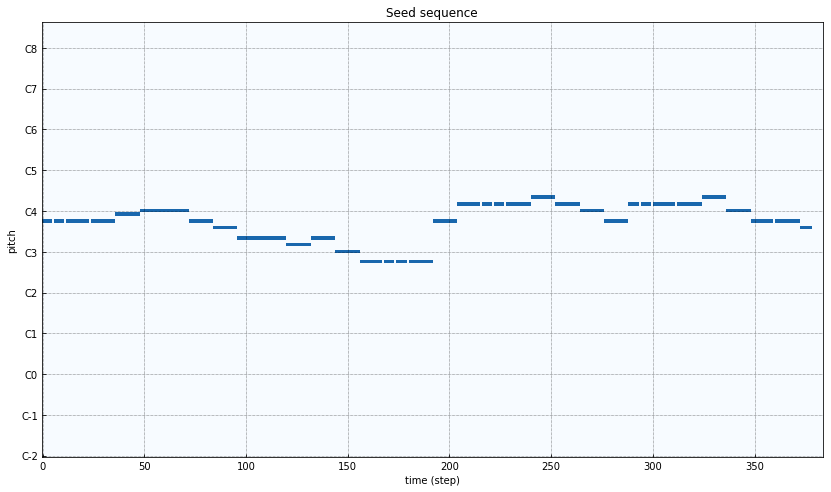

In [52]:
roll = pypianoroll.Multitrack(seedpath).tracks[0]

plt.figure(figsize=(14,8))
ax = plt.gca()
pypianoroll.plot_pianoroll(ax, roll.pianoroll)
plt.title("Seed sequence")
plt.show()

  0%|                                                                                                                                           | 0/10 [00:00<?, ?it/s]

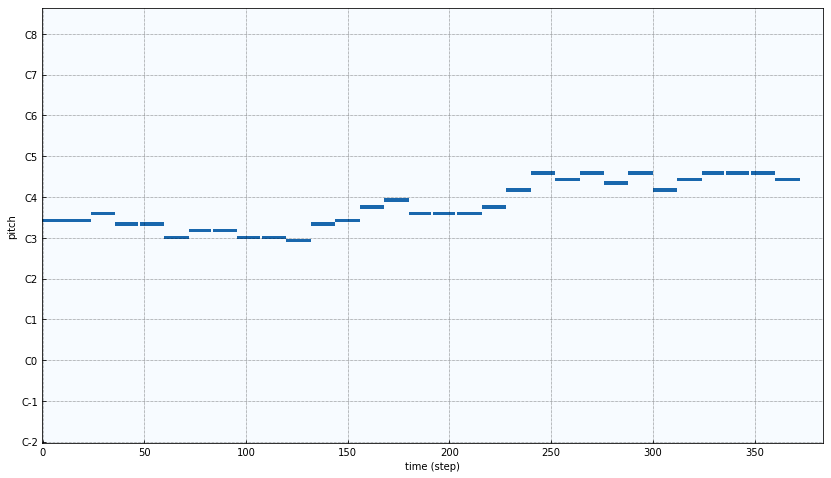

 10%|█████████████                                                                                                                      | 1/10 [00:01<00:09,  1.08s/it]

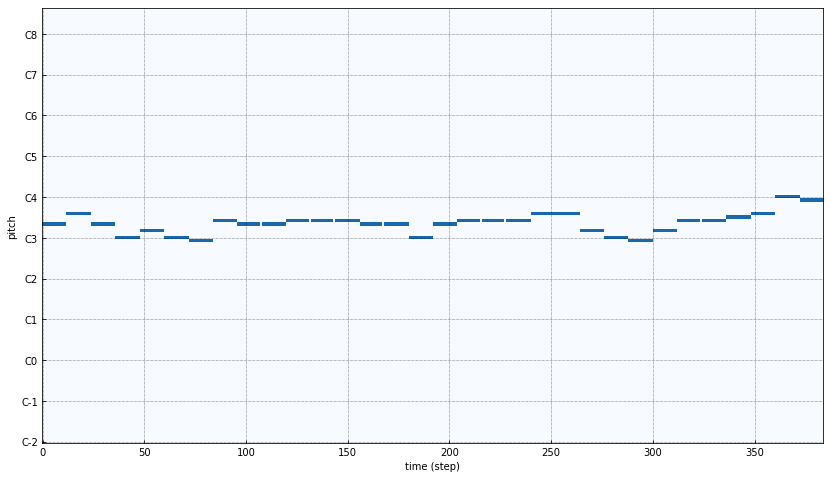

 20%|██████████████████████████▏                                                                                                        | 2/10 [00:01<00:07,  1.02it/s]

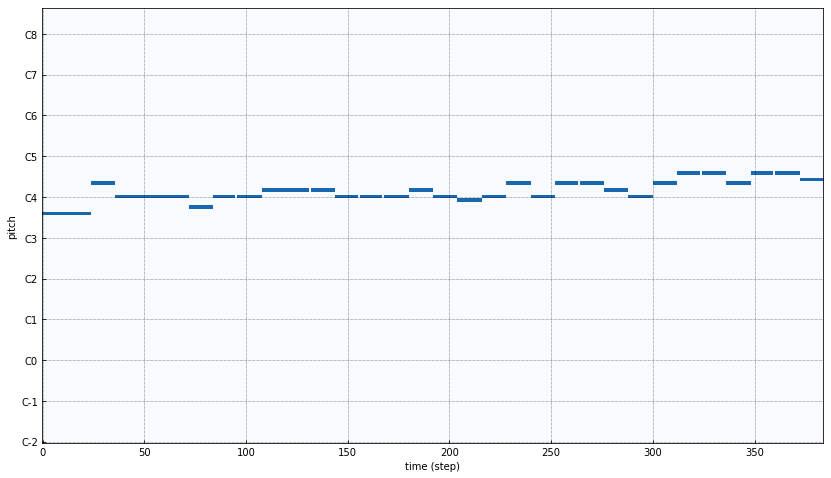

 30%|███████████████████████████████████████▎                                                                                           | 3/10 [00:02<00:06,  1.10it/s]

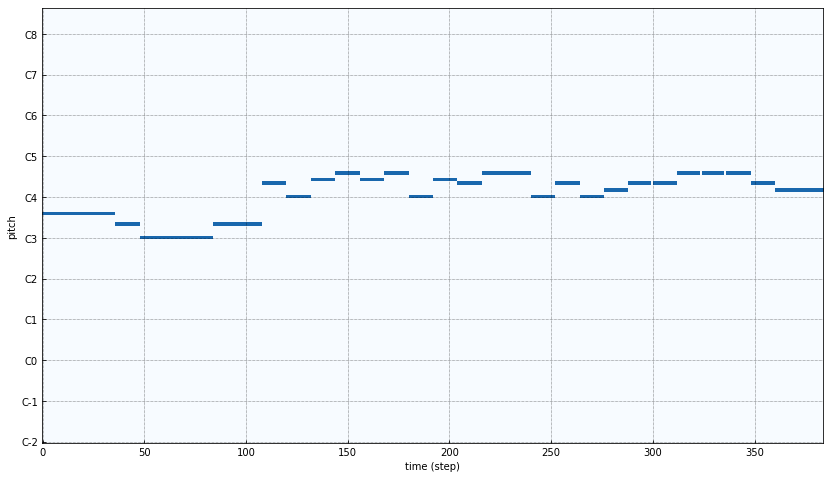

 40%|████████████████████████████████████████████████████▍                                                                              | 4/10 [00:03<00:05,  1.16it/s]

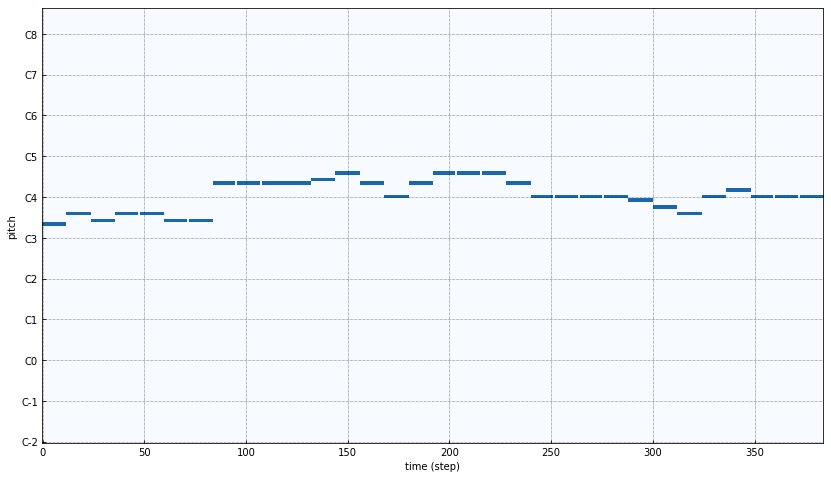

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 5/10 [00:04<00:04,  1.20it/s]

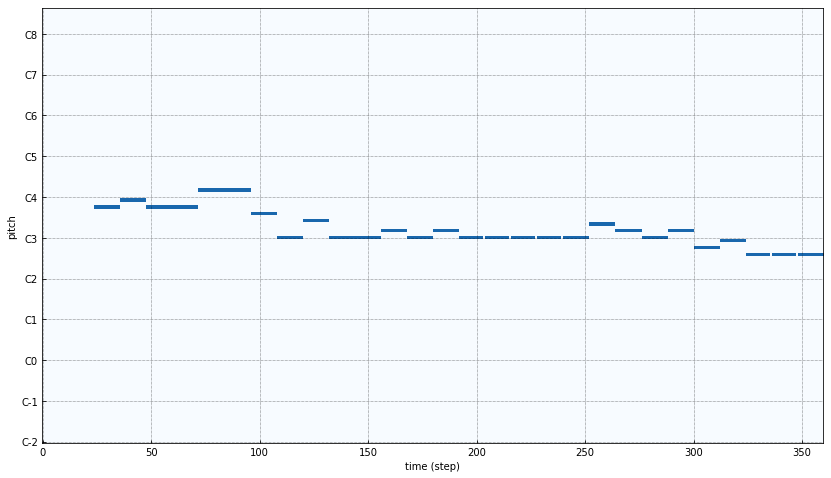

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 6/10 [00:04<00:03,  1.23it/s]

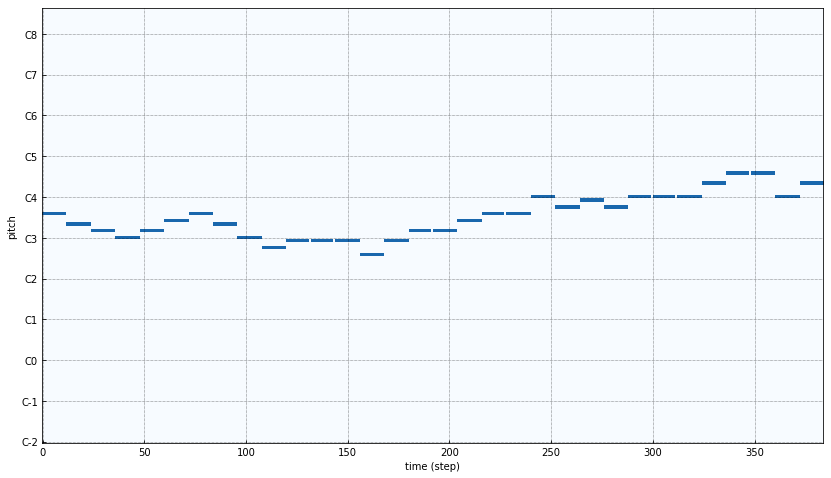

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7/10 [00:05<00:02,  1.26it/s]

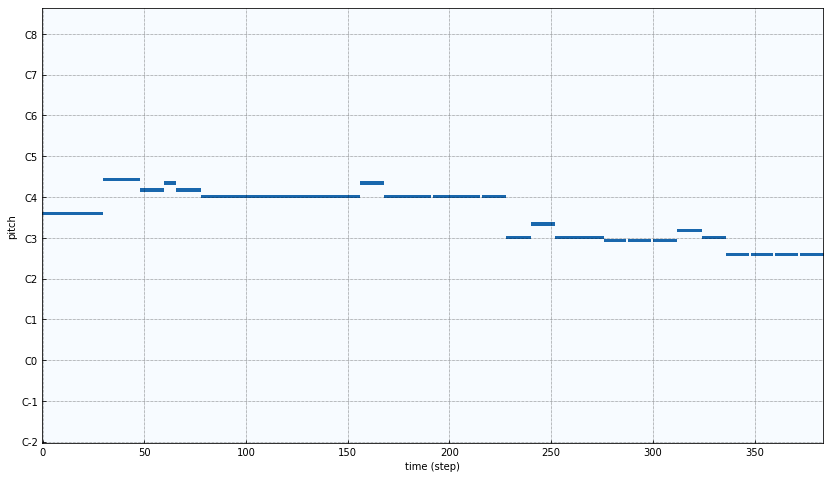

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8/10 [00:06<00:01,  1.27it/s]

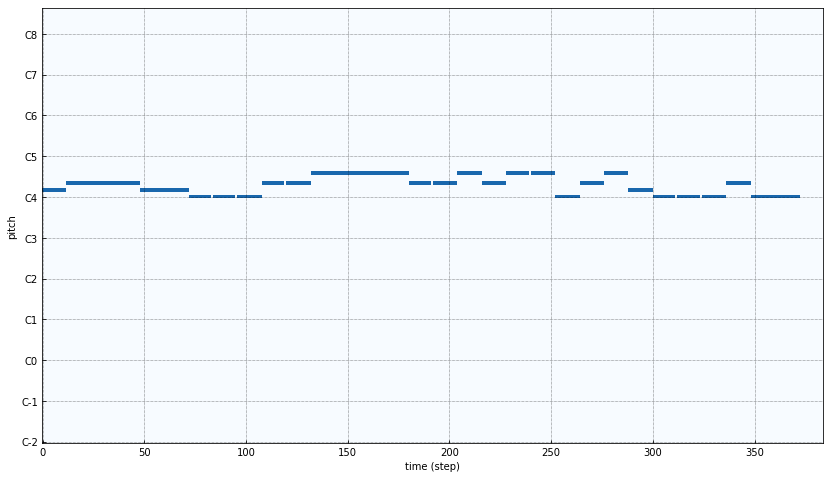

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9/10 [00:07<00:00,  1.27it/s]

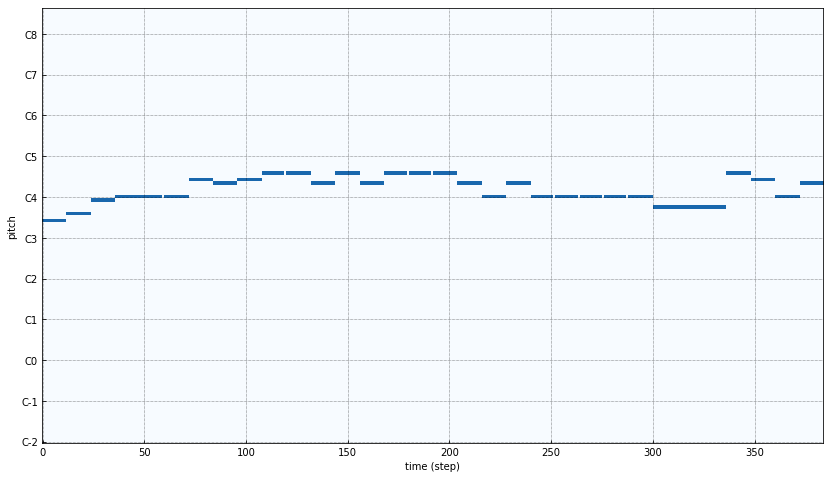

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


In [53]:
temperature = 1.0

nr_samples = 10

for i in tqdm(list(range(nr_samples))):
    
    for timestep in range(INPUT_SEQ_LEN, len(generated)):
        start_index = timestep - (INPUT_SEQ_LEN)
        sequence_for_prediction = generated[start_index:timestep]
#         next_step, att = sample(model, sequence_for_prediction, temperature, withatt=True)
        next_step = sample(model, sequence_for_prediction, temperature, withatt=False)
#         print(att.argsort()[-10:][::-1])
        generated[timestep] = next_step

    generated_noseed = generated[INPUT_SEQ_LEN:]
    new_path = os.path.join(samples_dir, "temp_%s_%s.mid" %(temperature, i))
    midi_io.note_sequence_to_midi_file(melodies_lib.Melody(
    [
        encoder.decode_event(ev) for ev in np.trim_zeros(np.argmax(generated_noseed,axis=1), 'f')
    ]
    ).to_sequence(), new_path)
    
    roll = pypianoroll.Multitrack(new_path).tracks[0]

    plt.figure(figsize=(14,8))
    ax = plt.gca()
    pypianoroll.plot_pianoroll(ax, roll.pianoroll)
    plt.show()

  0%|                                                                                                                                           | 0/10 [00:00<?, ?it/s]

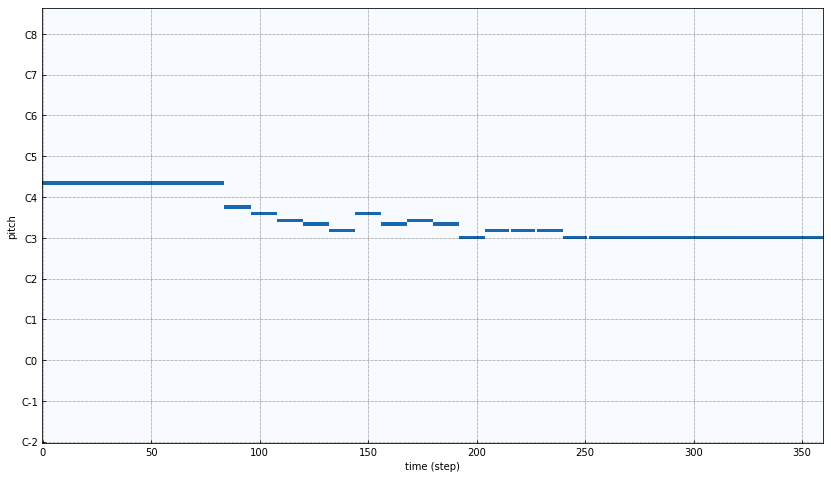

 10%|█████████████                                                                                                                      | 1/10 [00:01<00:09,  1.02s/it]

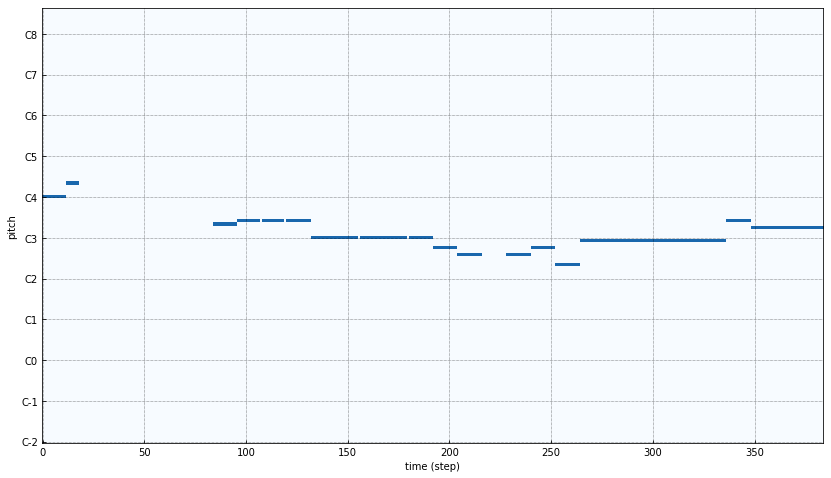

 20%|██████████████████████████▏                                                                                                        | 2/10 [00:01<00:07,  1.06it/s]

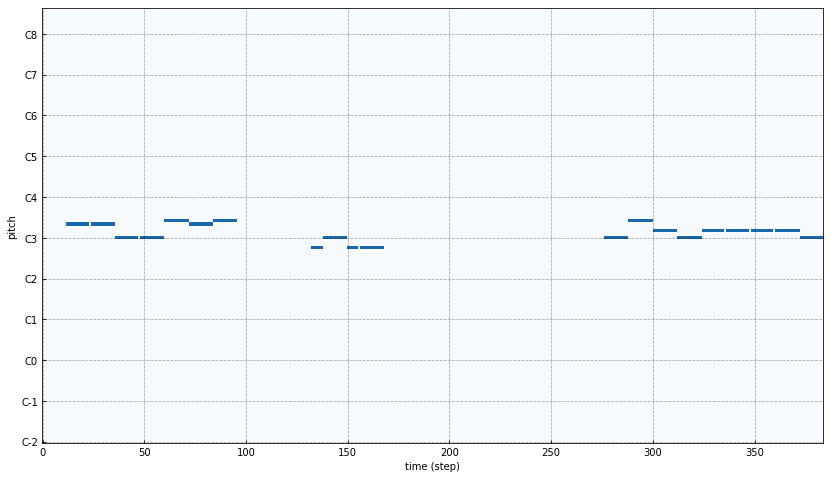

 30%|███████████████████████████████████████▎                                                                                           | 3/10 [00:02<00:06,  1.13it/s]

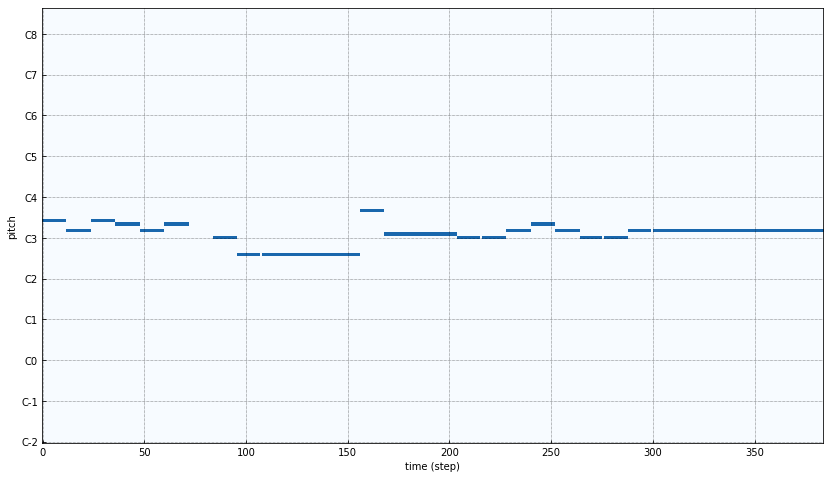

 40%|████████████████████████████████████████████████████▍                                                                              | 4/10 [00:03<00:05,  1.18it/s]

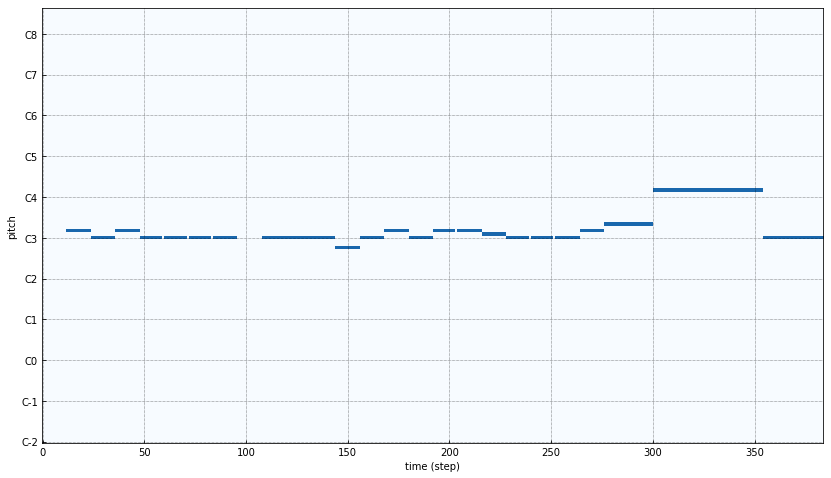

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 5/10 [00:04<00:04,  1.22it/s]

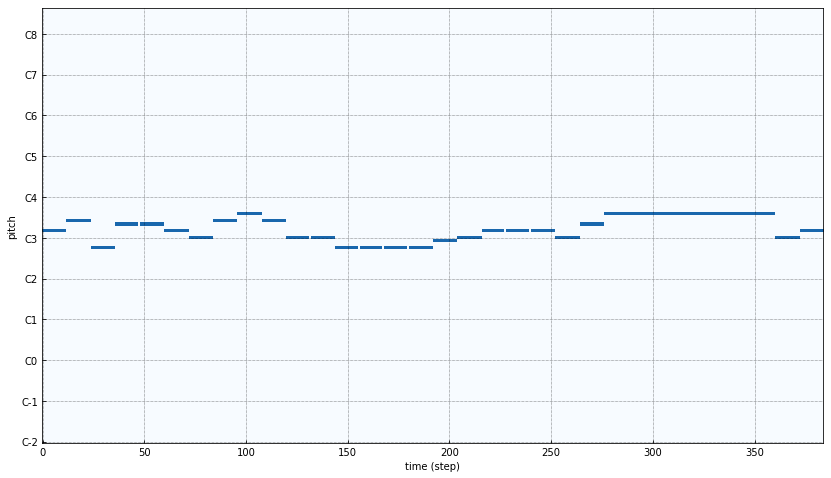

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 6/10 [00:04<00:03,  1.21it/s]

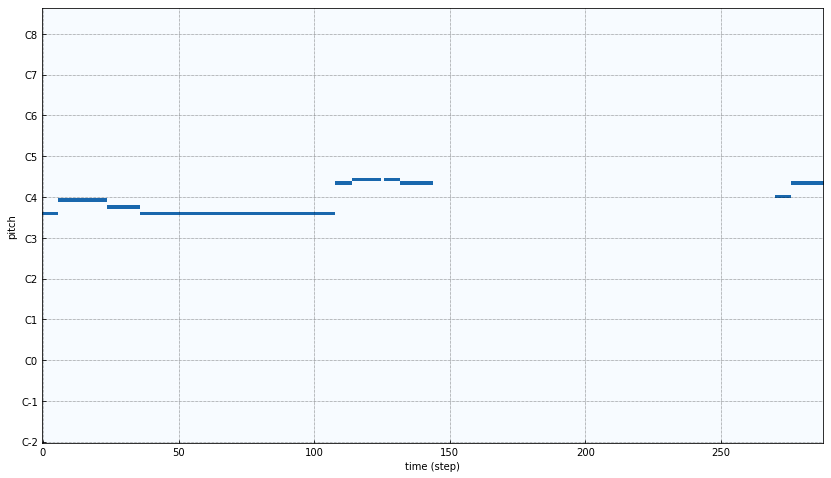

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7/10 [00:05<00:02,  1.24it/s]

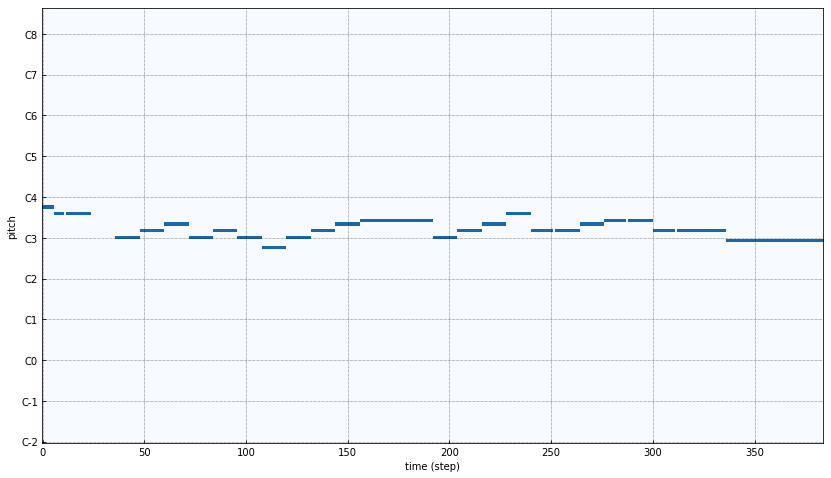

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8/10 [00:06<00:01,  1.27it/s]

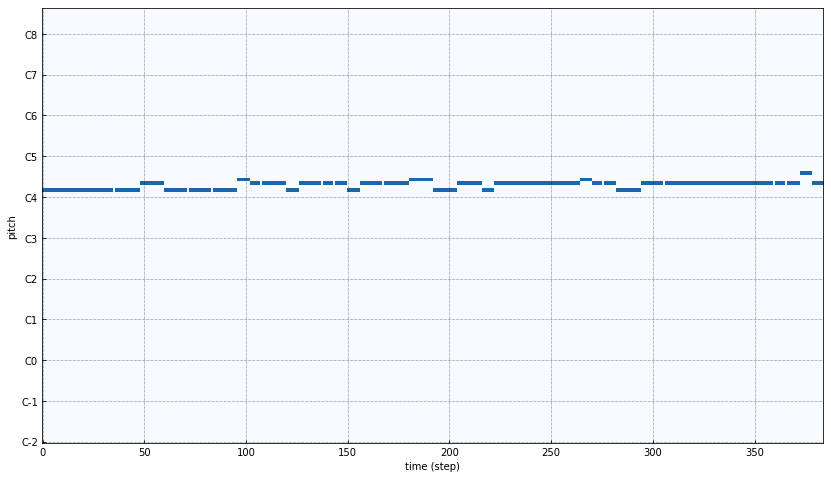

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9/10 [00:07<00:00,  1.29it/s]

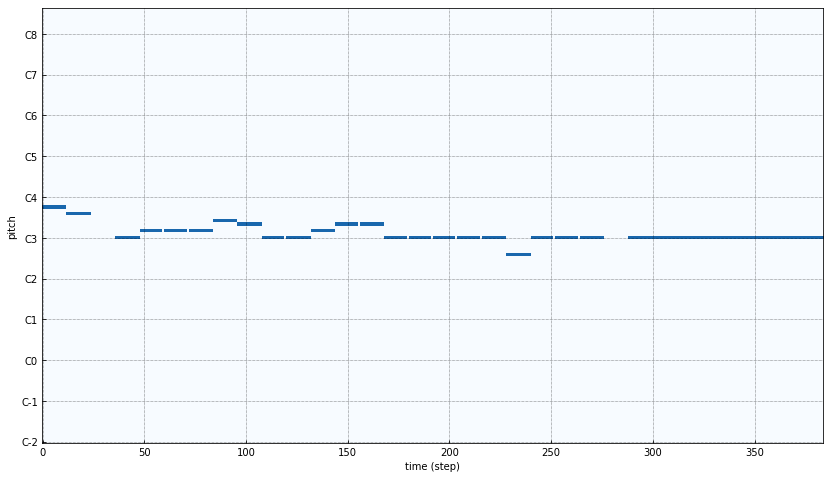

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


In [27]:
temperature = 1.0

nr_samples = 10

for i in tqdm(list(range(nr_samples))):
    
    for timestep in range(INPUT_SEQ_LEN, len(generated)):
        start_index = timestep - (INPUT_SEQ_LEN)
        sequence_for_prediction = generated[start_index:timestep]
#         next_step, att = sample(model, sequence_for_prediction, temperature, withatt=True)
        next_step = sample(model, sequence_for_prediction, temperature, withatt=False)
#         print(att.argsort()[-10:][::-1])
        generated[timestep] = next_step

    generated_noseed = generated[INPUT_SEQ_LEN:]
    new_path = os.path.join(samples_dir, "temp_%s_%s.mid" %(temperature, i))
    midi_io.note_sequence_to_midi_file(melodies_lib.Melody(
    [
        encoder.decode_event(ev) for ev in np.trim_zeros(np.argmax(generated_noseed,axis=1), 'f')
    ]
    ).to_sequence(), new_path)
    
    roll = pypianoroll.Multitrack(new_path).tracks[0]

    plt.figure(figsize=(14,8))
    ax = plt.gca()
    pypianoroll.plot_pianoroll(ax, roll.pianoroll)
    plt.show()

  0%|                                                                                                                                           | 0/10 [00:00<?, ?it/s]

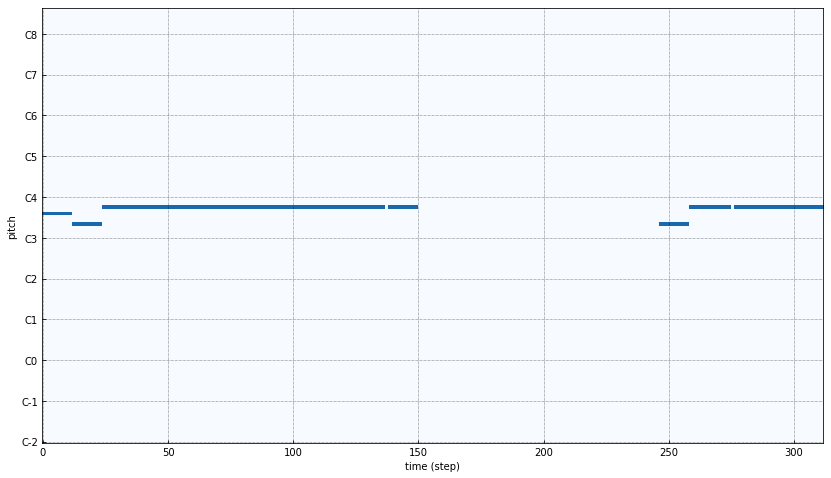

 10%|█████████████                                                                                                                      | 1/10 [00:00<00:06,  1.44it/s]

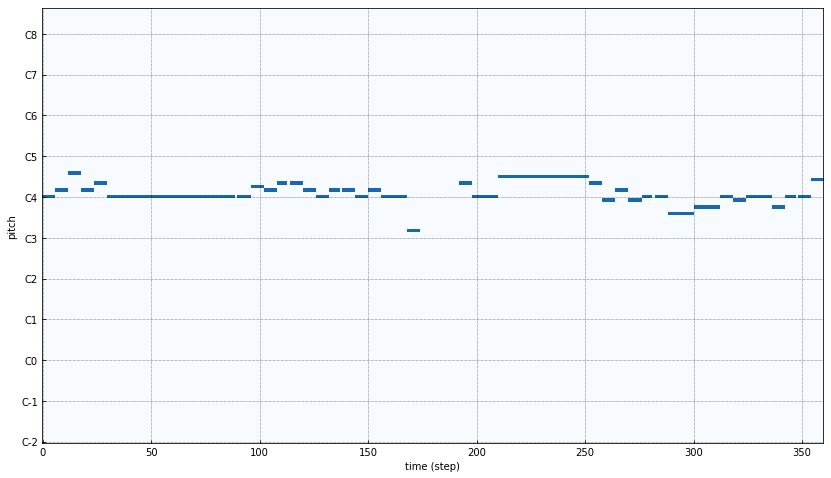

 20%|██████████████████████████▏                                                                                                        | 2/10 [00:01<00:05,  1.42it/s]

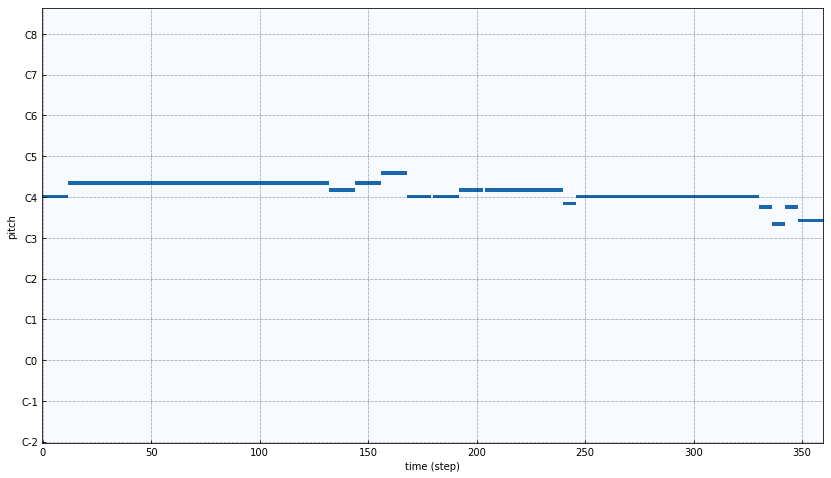

 30%|███████████████████████████████████████▎                                                                                           | 3/10 [00:02<00:05,  1.40it/s]

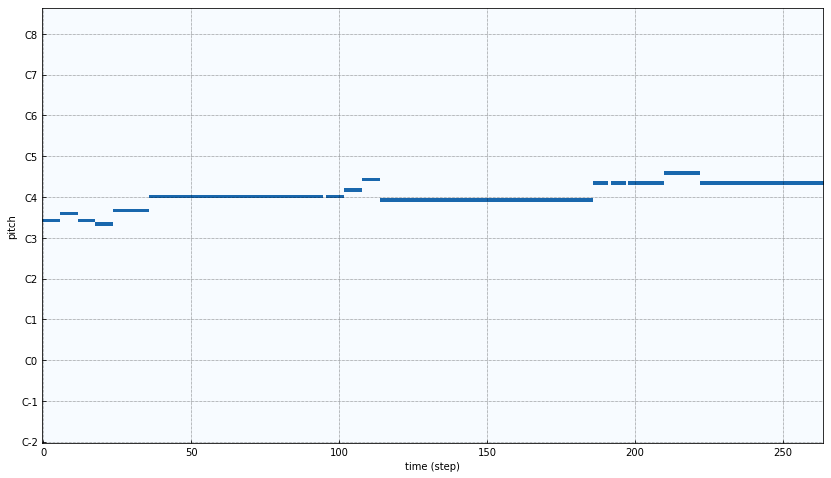

 40%|████████████████████████████████████████████████████▍                                                                              | 4/10 [00:02<00:04,  1.39it/s]

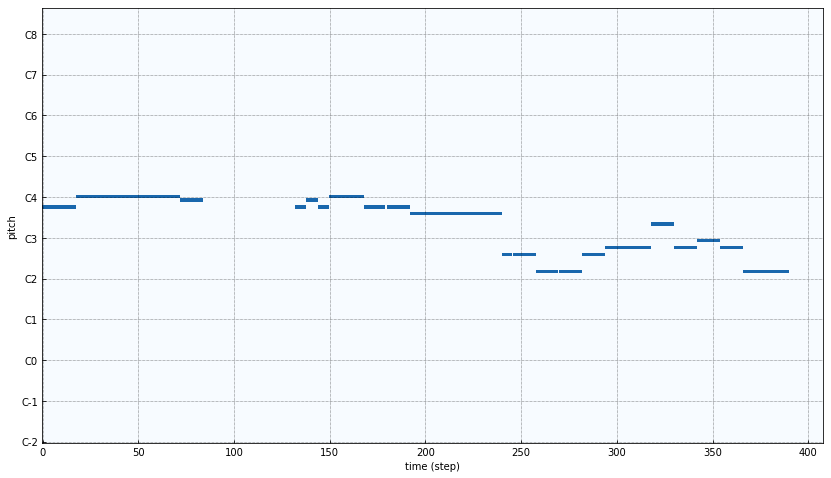

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 5/10 [00:03<00:03,  1.39it/s]

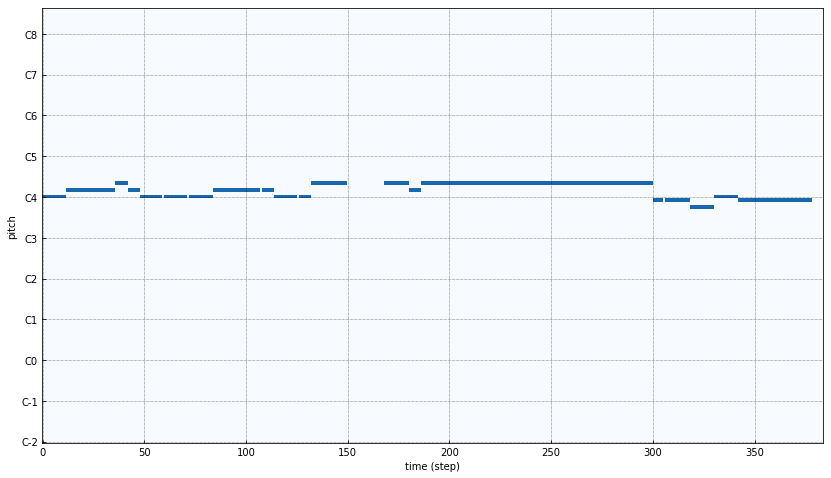

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 6/10 [00:04<00:02,  1.37it/s]

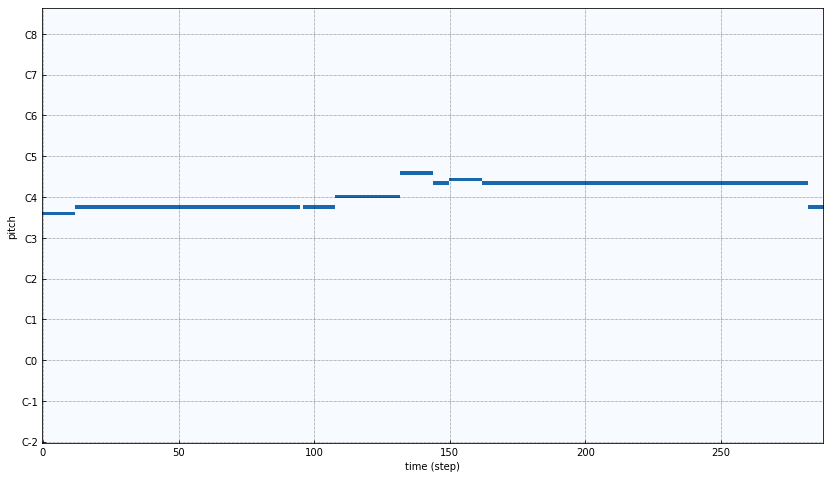

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7/10 [00:05<00:02,  1.37it/s]

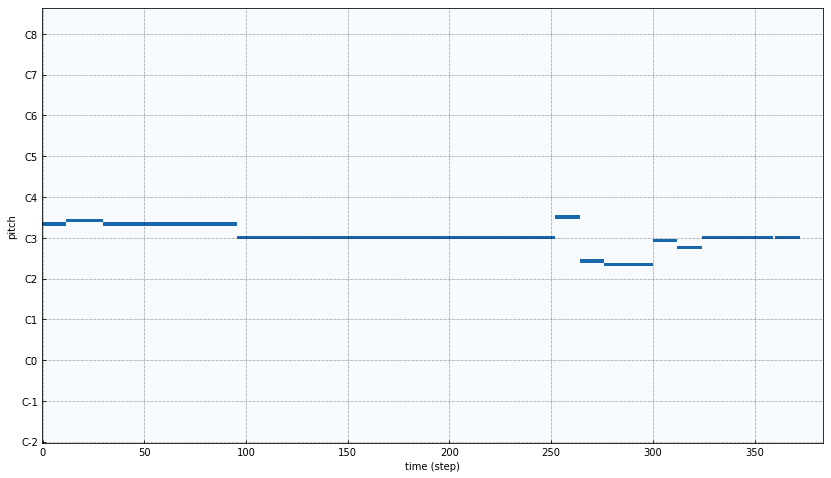

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8/10 [00:05<00:01,  1.38it/s]

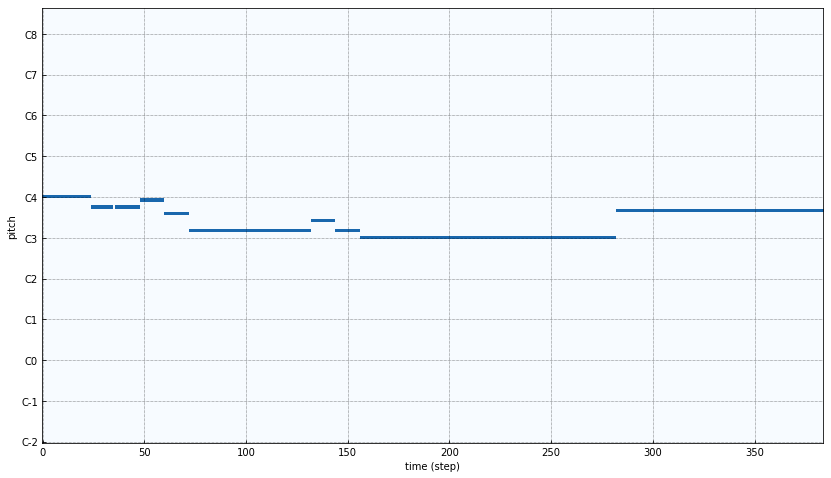

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9/10 [00:06<00:00,  1.38it/s]

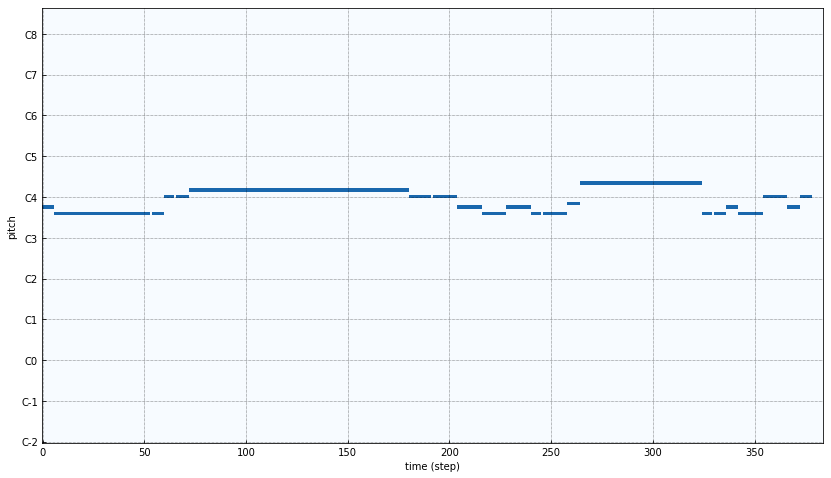

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


In [17]:
temperature = 1.0

nr_samples = 10

for i in tqdm(list(range(nr_samples))):
    
    for timestep in range(INPUT_SEQ_LEN, len(generated)):
        start_index = timestep - (INPUT_SEQ_LEN)
        sequence_for_prediction = generated[start_index:timestep]
#         next_step, att = sample(model, sequence_for_prediction, temperature, withatt=True)
        next_step = sample(model, sequence_for_prediction, temperature, withatt=False)
#         print(att.argsort()[-10:][::-1])
        generated[timestep] = next_step

    generated_noseed = generated[INPUT_SEQ_LEN:]
    new_path = os.path.join(samples_dir, "temp_%s_%s.mid" %(temperature, i))
    midi_io.note_sequence_to_midi_file(melodies_lib.Melody(
    [
        encoder.decode_event(ev) for ev in np.trim_zeros(np.argmax(generated_noseed,axis=1), 'f')
    ]
    ).to_sequence(), new_path)
    
    roll = pypianoroll.Multitrack(new_path).tracks[0]

    plt.figure(figsize=(14,8))
    ax = plt.gca()
    pypianoroll.plot_pianoroll(ax, roll.pianoroll)
    plt.show()